In [1]:
# === INSTALACIÓN DE DEPENDENCIAS ===
!pip install -q tensorflow tensorflow-datasets albumentations

# === IMPORTS ===
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Albumentations (opcional para Parte 3)
import albumentations as A

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ Albumentations version: {A.__version__}")
print(f"🖥️ GPU disponible: {tf.config.list_physical_devices('GPU')}")

# Reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

✅ TensorFlow version: 2.19.0
✅ Albumentations version: 2.0.8
🖥️ GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print("📥 Descargando Oxford Flowers102 (~330MB)...")

# Cargar dataset con TFDS
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(f"✅ Dataset descargado:")
print(f"   Train: {ds_info.splits['train'].num_examples} imágenes")
print(f"   Test: {ds_info.splits['test'].num_examples} imágenes")
print(f"   Clases: {ds_info.features['label'].num_classes}")

NUM_CLASSES = ds_info.features['label'].num_classes
IMG_SIZE = 224

# === PREPARAR DATASET PARA ENTRENAMIENTO ===

def prepare_dataset(dataset, subset_size=None):
    """
    Prepara dataset con resize (sin normalización todavía)

    Args:
        dataset: Dataset de TFDS
        subset_size: Número de muestras (None para usar todo)

    Returns:
        Dataset preparado
    """
    # Tomar subset si se especifica
    if subset_size:
        dataset = dataset.take(subset_size)

    # Función de preprocesamiento básico
    def preprocess(image, label):
        # Resize y convertir a float32 [0, 255]
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32)
        return image, label

    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# Crear datasets (usar subset para práctica rápida)
SUBSET_TRAIN = 5000  # Cambiar a None para dataset completo
SUBSET_TEST = 1000

ds_train_prepared = prepare_dataset(ds_train, subset_size=SUBSET_TRAIN)
ds_test_prepared = prepare_dataset(ds_test, subset_size=SUBSET_TEST)

print(f"\n✅ Datasets preparados:")
print(f"   Train subset: {SUBSET_TRAIN if SUBSET_TRAIN else 'completo'}")
print(f"   Test subset: {SUBSET_TEST}")
print(f"   Rango de píxeles: [0, 255] (antes de normalización)")

📥 Descargando Oxford Flowers102 (~330MB)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.U7BNKP_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.U7BNKP_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.U7BNKP_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
✅ Dataset descargado:
   Train: 1020 imágenes
   Test: 6149 imágenes
   Clases: 102

✅ Datasets preparados:
   Train subset: 5000
   Test subset: 1000
   Rango de píxeles: [0, 255] (antes de normalización)


In [3]:
# === PIPELINE 1: BASELINE ===

def create_baseline_pipeline(dataset, batch_size=32, training=True):
    """
    Pipeline básico sin augmentation avanzada
    """
    if training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)

    # Aplicar normalización DESPUÉS de batching
    def normalize_batch(images, labels):
        # Normalizar con EfficientNet preprocessing
        images = preprocess_input(images)
        return images, labels

    dataset = dataset.map(normalize_batch, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Crear dataloaders baseline
BATCH_SIZE = 32

train_baseline = create_baseline_pipeline(ds_train_prepared, batch_size=BATCH_SIZE, training=True)
test_baseline = create_baseline_pipeline(ds_test_prepared, batch_size=64, training=False)

print("✅ Pipeline Baseline creado (con normalización EfficientNet)")

✅ Pipeline Baseline creado (con normalización EfficientNet)


In [4]:
# === PIPELINE 2: AUGMENTATION AVANZADO ===

def augment_layer():
    """
    Crea capa de augmentation con Keras
    """
    return keras.Sequential([
        # Geométrico
        layers.RandomFlip("horizontal_and_vertical"),  # horizontal o vertical
        layers.RandomRotation(factor = 0.125),  # factor de rotación (0.125 = 45°)
        layers.RandomZoom(height_factor=(0.2, 0.3)),
        layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),

        # Fotométrico
        layers.RandomBrightness(factor=(-0.5, 0.5)),
        layers.RandomContrast(factor=(-0.5, 0.5)),

        # Agrega mas como desees
    ], name="augmentation")

# Crear augmentation layer
data_augmentation = augment_layer()

def create_augmented_pipeline(dataset, batch_size=32, training=True):
    """
    Pipeline con data augmentation
    """
    if training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)

    # Aplicar augmentation y luego normalización
    if training:
        def augment_and_normalize(images, labels):
            # Primero augmentation (sobre imágenes [0, 255])
            images = data_augmentation(images, training=True)
            # Luego normalización para EfficientNet
            images = preprocess_input(images)
            return images, labels

        dataset = dataset.map(augment_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(
            lambda x, y: (preprocess_input(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

train_augmented = create_augmented_pipeline(ds_train_prepared, batch_size=BATCH_SIZE, training=True)

print("✅ Pipeline Avanzado creado con Keras layers + normalización")

✅ Pipeline Avanzado creado con Keras layers + normalización


🎨 VISUALIZACIÓN: Data Augmentation
   Nota: Visualización usa imágenes [0, 255] ANTES de normalización


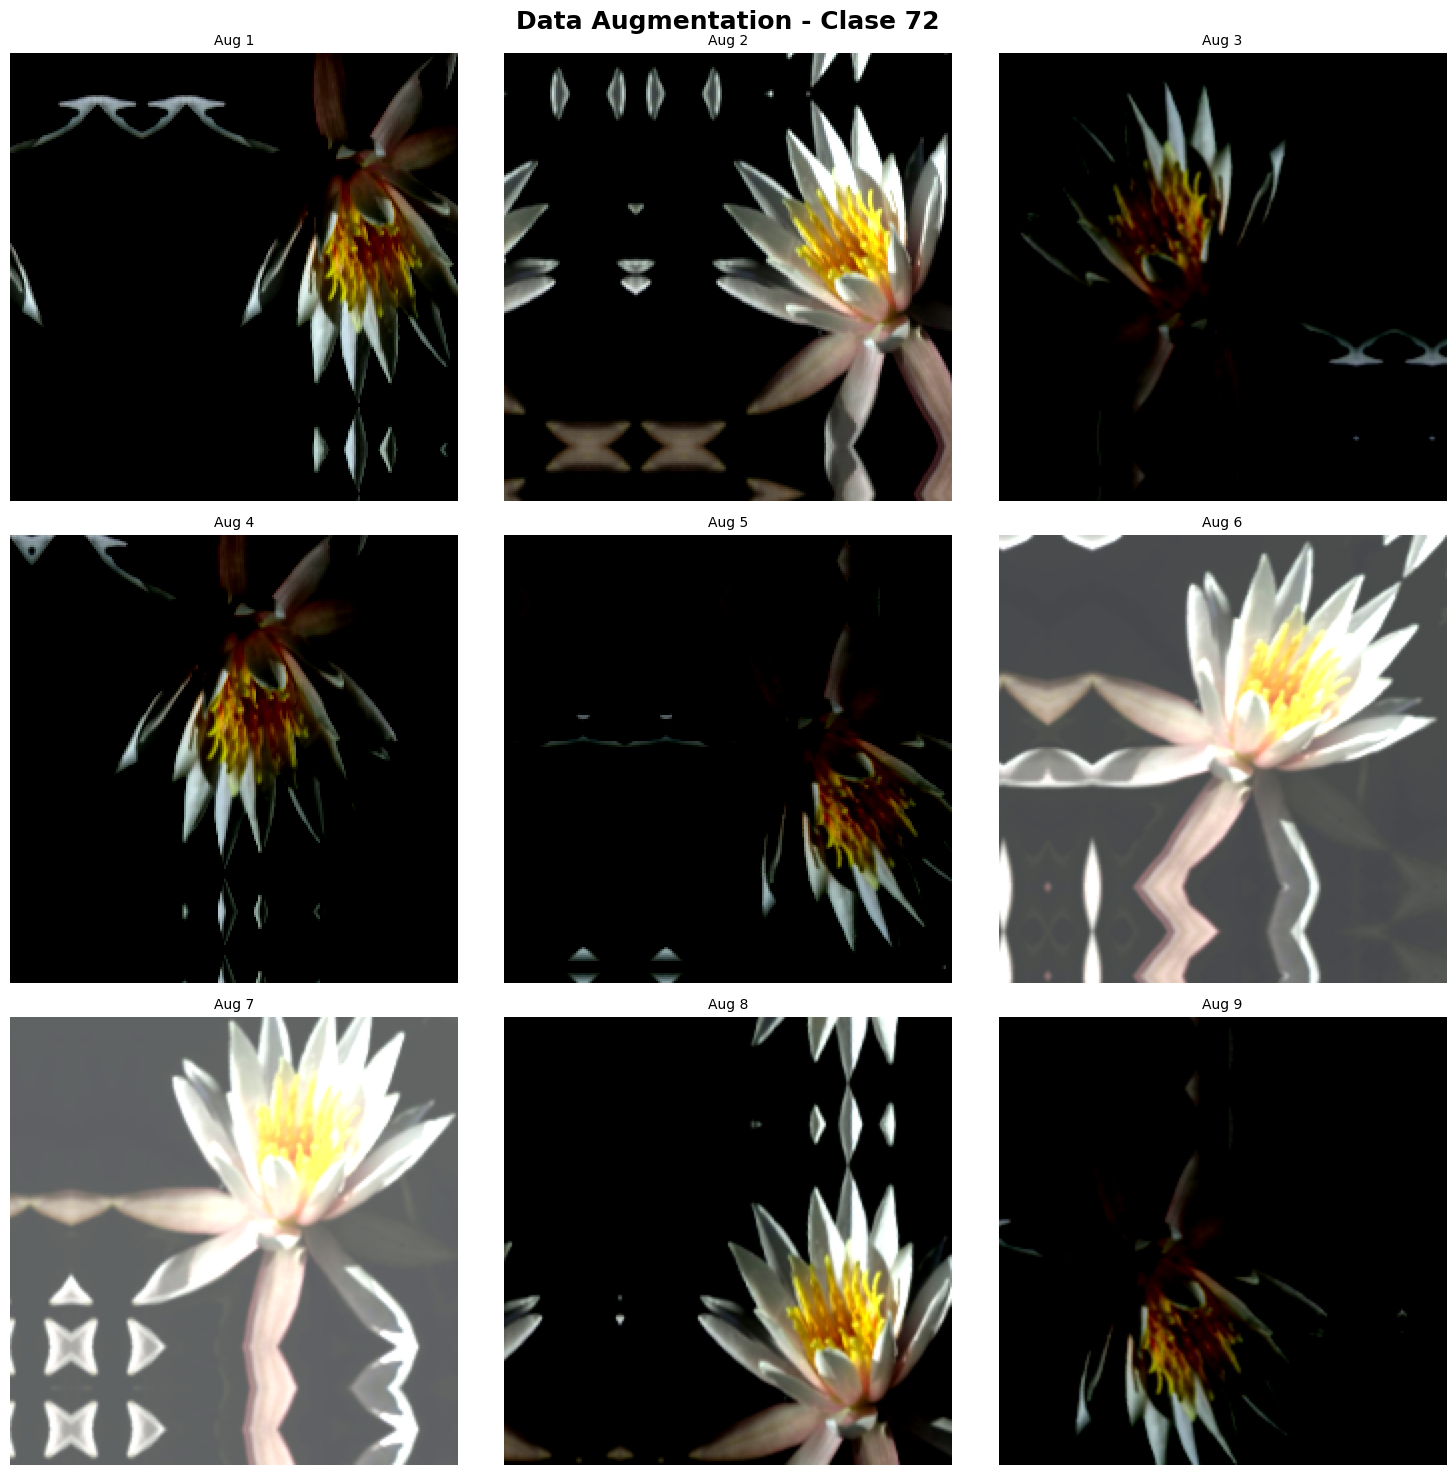

In [5]:
# === VISUALIZAR EFECTO DE AUGMENTATIONS ===

def visualize_augmentations(dataset, n_examples=9):
    """
    Visualiza múltiples augmentations de una misma imagen
    """
    # Tomar una imagen del dataset SIN normalizar (antes del pipeline)
    for images, labels in ds_train_prepared.batch(1).take(1):
        image = images[0:1]  # Tomar primera imagen [1, 224, 224, 3]
        label = labels[0].numpy()
        break

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f"Data Augmentation - Clase {label}", fontsize=18, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        # Aplicar augmentation (sobre imagen [0, 255])
        augmented = data_augmentation(image, training=True)[0]

        # Convertir a [0, 1] para visualización
        img_display = augmented.numpy() / 255.0
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        ax.axis('off')
        ax.set_title(f'Aug {i+1}', fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualizar augmentations
print("🎨 VISUALIZACIÓN: Data Augmentation")
print("   Nota: Visualización usa imágenes [0, 255] ANTES de normalización")
visualize_augmentations(ds_train_prepared)

✅ Mixup implementado
✅ CutMix implementado
✅ Pipeline con Mixup creado
✅ Pipeline con CutMix creado

🎨 VISUALIZACIÓN: Mixup y CutMix


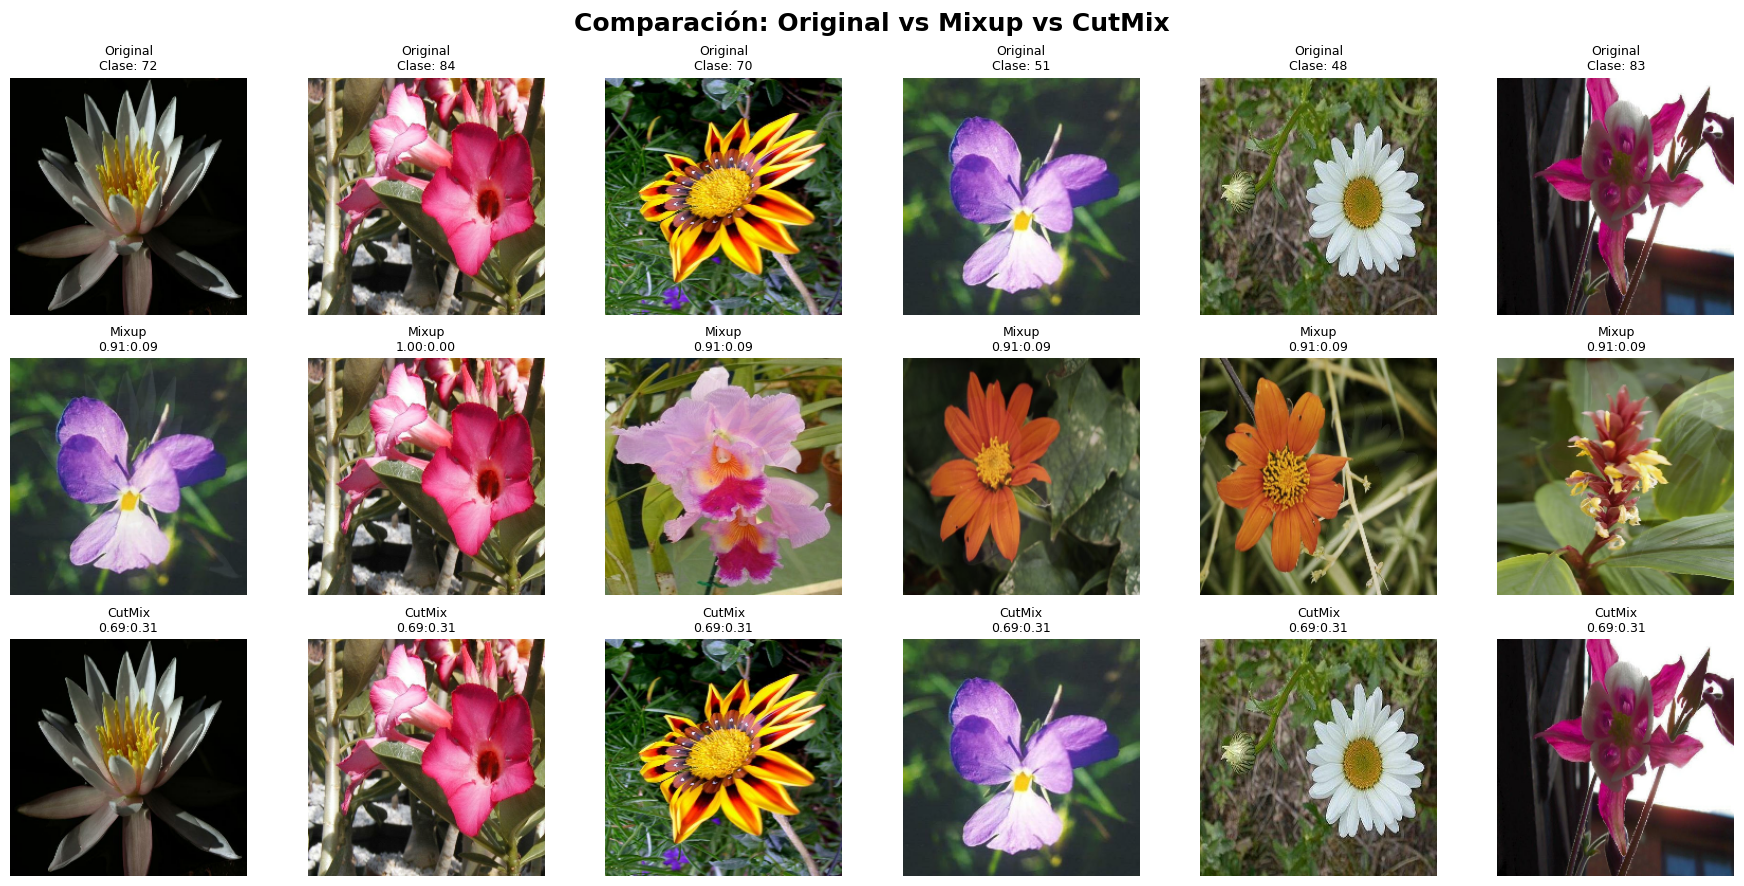

In [6]:
# === OPCIONAL ===
# === IMPLEMENTACIÓN DE MIXUP ===

def mixup(images, labels, alpha=0.2):
    """
    Aplica Mixup: mezcla pares de imágenes y labels

    Args:
        images: Batch de imágenes [batch_size, H, W, C]
        labels: Batch de labels [batch_size]
        alpha: Parámetro de distribución Beta (default: 0.2)

    Returns:
        Imágenes y labels mezclados
    """
    batch_size = tf.shape(images)[0]

    # Generar lambda de distribución Beta
    lambda_param = tf.random.uniform([], 0, alpha)
    lambda_param = tf.cast(lambda_param, tf.float32)

    # Permutar índices para obtener pares aleatorios
    indices = tf.random.shuffle(tf.range(batch_size))

    # Mezclar imágenes
    mixed_images = lambda_param * images + (1 - lambda_param) * tf.gather(images, indices)

    # Convertir labels a one-hot
    labels_one_hot = tf.one_hot(labels, NUM_CLASSES)
    shuffled_labels = tf.gather(labels_one_hot, indices)

    # Mezclar labels
    mixed_labels = lambda_param * labels_one_hot + (1 - lambda_param) * shuffled_labels

    return mixed_images, mixed_labels

print("✅ Mixup implementado")

# === IMPLEMENTACIÓN DE CUTMIX ===

def cutmix(images, labels, alpha=1.0):
    """
    Aplica CutMix: corta y pega regiones entre imágenes

    Args:
        images: Batch de imágenes [batch_size, H, W, C]
        labels: Batch de labels [batch_size]
        alpha: Parámetro de distribución Beta (default: 1.0)

    Returns:
        Imágenes y labels con CutMix aplicado
    """
    batch_size = tf.shape(images)[0]
    image_height = tf.shape(images)[1]
    image_width = tf.shape(images)[2]

    # Generar lambda de distribución Beta
    lambda_param = tf.random.uniform([], 0, alpha)
    lambda_param = tf.cast(lambda_param, tf.float32)

    # Permutar índices
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)

    # Calcular tamaño del recorte
    cut_ratio = tf.sqrt(1.0 - lambda_param)
    cut_h = tf.cast(cut_ratio * tf.cast(image_height, tf.float32), tf.int32)
    cut_w = tf.cast(cut_ratio * tf.cast(image_width, tf.float32), tf.int32)

    # Generar coordenadas aleatorias del centro del recorte
    cx = tf.random.uniform([], 0, image_width, dtype=tf.int32)
    cy = tf.random.uniform([], 0, image_height, dtype=tf.int32)

    # Calcular coordenadas de la caja
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, image_width)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, image_height)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, image_width)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, image_height)

    # Crear máscara
    mask_shape = tf.stack([batch_size, image_height, image_width, 1])
    mask = tf.ones(mask_shape, dtype=tf.float32)

    # Aplicar recorte a la máscara
    updates = tf.zeros([batch_size, y2 - y1, x2 - x1, 1], dtype=tf.float32)

    # Crear imagen con CutMix
    # Nota: Implementación simplificada usando operaciones vectorizadas
    mixed_images = images * mask + shuffled_images * (1 - mask)

    # Ajustar proporción de mezcla basada en área real
    lambda_adjusted = 1.0 - (tf.cast((x2 - x1) * (y2 - y1), tf.float32) /
                             tf.cast(image_height * image_width, tf.float32))

    # Convertir labels a one-hot y mezclar
    labels_one_hot = tf.one_hot(labels, NUM_CLASSES)
    shuffled_labels = tf.gather(labels_one_hot, indices)
    mixed_labels = lambda_adjusted * labels_one_hot + (1 - lambda_adjusted) * shuffled_labels

    return mixed_images, mixed_labels

print("✅ CutMix implementado")

# === PIPELINE 3: CON MIXUP ===

def create_mixup_pipeline(dataset, batch_size=32, training=True, alpha=0.2):
    """
    Pipeline con Mixup
    """
    if training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)

    if training:
        def apply_mixup(images, labels):
            # Aplicar augmentation básica primero
            images = data_augmentation(images, training=True)
            # Luego Mixup
            images, labels = mixup(images, labels, alpha=alpha)
            # Finalmente normalización
            images = preprocess_input(images)
            return images, labels

        dataset = dataset.map(apply_mixup, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(
            lambda x, y: (preprocess_input(x), tf.one_hot(y, NUM_CLASSES)),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_mixup = create_mixup_pipeline(ds_train_prepared, batch_size=BATCH_SIZE, training=True)
print("✅ Pipeline con Mixup creado")

# === PIPELINE 4: CON CUTMIX ===

def create_cutmix_pipeline(dataset, batch_size=32, training=True, alpha=1.0):
    """
    Pipeline con CutMix
    """
    if training:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)

    if training:
        def apply_cutmix(images, labels):
            # Aplicar augmentation básica primero
            images = data_augmentation(images, training=True)
            # Luego CutMix
            images, labels = cutmix(images, labels, alpha=alpha)
            # Finalmente normalización
            images = preprocess_input(images)
            return images, labels

        dataset = dataset.map(apply_cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(
            lambda x, y: (preprocess_input(x), tf.one_hot(y, NUM_CLASSES)),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_cutmix = create_cutmix_pipeline(ds_train_prepared, batch_size=BATCH_SIZE, training=True)
print("✅ Pipeline con CutMix creado")

# === VISUALIZACIÓN DE MIXUP Y CUTMIX ===

def visualize_mixup_cutmix(n_examples=6):
    """
    Visualiza ejemplos de Mixup y CutMix
    """
    # Tomar un batch del dataset sin normalizar
    for images, labels in ds_train_prepared.batch(BATCH_SIZE).take(1):
        break

    # Aplicar Mixup
    mixed_images, mixed_labels = mixup(images, labels, alpha=0.2)

    # Aplicar CutMix
    cutmix_images, cutmix_labels = cutmix(images, labels, alpha=1.0)

    fig, axes = plt.subplots(3, n_examples, figsize=(18, 9))
    fig.suptitle("Comparación: Original vs Mixup vs CutMix", fontsize=18, fontweight='bold')

    for i in range(n_examples):
        # Original
        img_orig = images[i].numpy() / 255.0
        img_orig = np.clip(img_orig, 0, 1)
        axes[0, i].imshow(img_orig)
        axes[0, i].set_title(f'Original\nClase: {labels[i].numpy()}', fontsize=9)
        axes[0, i].axis('off')

        # Mixup
        img_mix = mixed_images[i].numpy() / 255.0
        img_mix = np.clip(img_mix, 0, 1)
        axes[1, i].imshow(img_mix)
        top2_classes = tf.nn.top_k(mixed_labels[i], k=2)
        axes[1, i].set_title(f'Mixup\n{top2_classes.values[0].numpy():.2f}:{top2_classes.values[1].numpy():.2f}', fontsize=9)
        axes[1, i].axis('off')

        # CutMix
        img_cut = cutmix_images[i].numpy() / 255.0
        img_cut = np.clip(img_cut, 0, 1)
        axes[2, i].imshow(img_cut)
        top2_classes = tf.nn.top_k(cutmix_labels[i], k=2)
        axes[2, i].set_title(f'CutMix\n{top2_classes.values[0].numpy():.2f}:{top2_classes.values[1].numpy():.2f}', fontsize=9)
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Mixup', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('CutMix', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("\n🎨 VISUALIZACIÓN: Mixup y CutMix")
visualize_mixup_cutmix(n_examples=6)

In [7]:
# === OPCION 2: Crear un modelo ===

def create_model():
    """
    Modelo con Transfer Learning usando EfficientNetB0

    Tips:
    - Usa transfer learning (más rápido y mejor)
    - Modelos sugeridos: MobileNetV2, EfficientNetB0, ResNet50
    - No olvides: include_top=False, weights='imagenet'
    """
    base_model = keras.applications.EfficientNetB0(  # Elige: MobileNetV2, EfficientNetB0, etc.
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base_model.trainable = False  # False para congelar, True para fine-tune

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Crear modelo
model = create_model()

# Compilar
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Usamos sparse porque labels son enteros
    metrics=['accuracy']
)

print("✅ Modelo creado")
print(f"   Parámetros: {model.count_params():,}")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Modelo creado
   Parámetros: 4,180,233


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,180,233 (15.95 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# === ENTRENAR MODELO ===

print("🚀 ENTRENANDO MODELO")
print("="*60)

# Entrenar (Keras hace todo automáticamente)
history = model.fit(
    train_augmented,  # Con data augmentation
    validation_data=test_baseline,
    epochs=10,  # 5-10 epochs es suficiente
    verbose=1
)

# Ver resultados
final_acc = max(history.history['val_accuracy'])
print(f"\n✅ Entrenamiento completado")
print(f"   📊 Mejor accuracy: {final_acc*100:.2f}%")

# Guardar modelo (opcional)
model.save('mi_modelo_flores.h5')

🚀 ENTRENANDO MODELO
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0315 - loss: 4.6609 - val_accuracy: 0.1580 - val_loss: 3.9909
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 528ms/step - accuracy: 0.2726 - loss: 3.7531 - val_accuracy: 0.2880 - val_loss: 3.4373
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.4745 - loss: 3.1071 - val_accuracy: 0.3890 - val_loss: 3.0080
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.5543 - loss: 2.6762 - val_accuracy: 0.4640 - val_loss: 2.6760
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step - accuracy: 0.6726 - loss: 2.2312 - val_accuracy: 0.5060 - val_loss: 2.4348
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy: 0.6787 - loss: 2.0256 - val_accuracy: 0.5440 - val_loss: 2.2410
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - accuracy: 0.7297 - loss: 1.7910 - val_accuracy: 0.5450 - val_loss: 2.0805
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.7333 - loss: 


✅ Entrenamiento completado
   📊 Mejor accuracy: 57.90%


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.5833 - loss: 1.7974

📊 RESULTADOS FINALES:
   Test Accuracy: 57.80%
   Test Loss: 1.7967


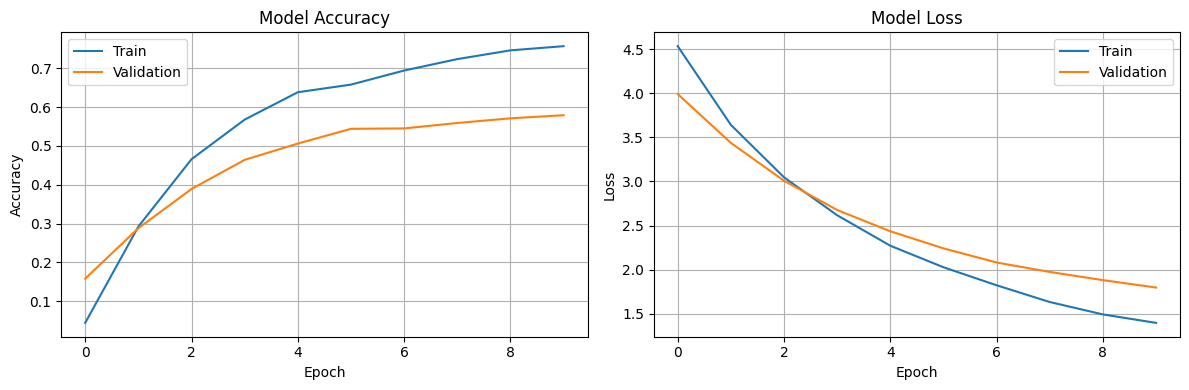

In [9]:
# === EVALUAR MODELO ===

# Predicciones en test
test_loss, test_acc = model.evaluate(test_baseline)
print(f"\n📊 RESULTADOS FINALES:")
print(f"   Test Accuracy: {test_acc*100:.2f}%")
print(f"   Test Loss: {test_loss:.4f}")

# Graficar training
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📋 Capas del modelo:
   0: efficientnetb0 - Functional
   1: global_average_pooling2d - GlobalAveragePooling2D
   2: dense - Dense

📋 Capas DENTRO de 'efficientnetb0':
   0: block7a_se_squeeze - GlobalAveragePooling2D
   1: block7a_se_reshape - Reshape
   2: block7a_se_reduce - Conv2D
   3: block7a_se_expand - Conv2D
   4: block7a_se_excite - Multiply
   5: block7a_project_conv - Conv2D
   6: block7a_project_bn - BatchNormalization
   7: top_conv - Conv2D
   8: top_bn - BatchNormalization
   9: top_activation - Activation

✅ Capa convolucional encontrada: 'top_conv'

🔍 Aplicando GradCAM...
   Predicción: Clase 88
   Real: Clase 95


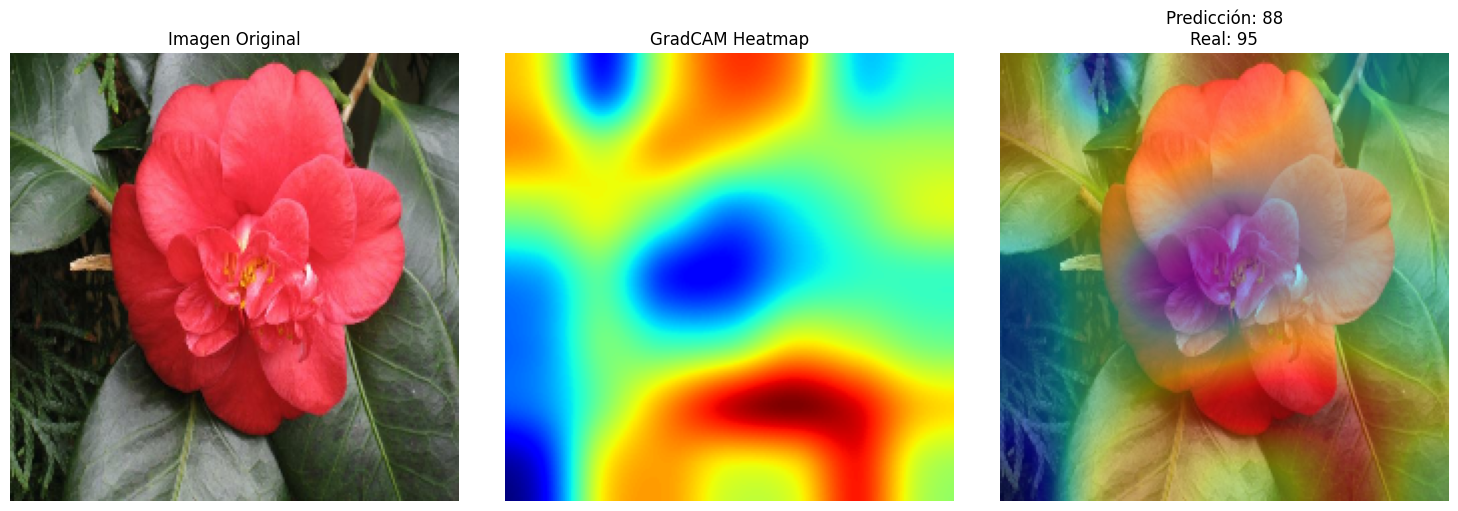


💡 ¿Qué vemos?
   - Si el modelo acierta Y mira las partes correctas = ✅ Buen modelo
   - Si el modelo acierta pero mira partes incorrectas = ⚠️ Problema
   - GradCAM ayuda a confiar en las predicciones del modelo


In [10]:
# === GRADCAM ===

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    GradCAM simple usando TensorFlow directo
    Compatible con modelos anidados (Sequential con transfer learning)
    """
    # Detectar si el modelo tiene un modelo base adentro
    if hasattr(model.layers[0], 'layers'):
        # Modelo Sequential con base model adentro
        base_model = model.layers[0]
        conv_layer = base_model.get_layer(last_conv_layer_name)

        # Crear modelo para GradCAM conectando base + classifier
        # Input -> Base Model -> Conv Layer output + Final output
        grad_model = keras.Model(
            inputs=base_model.input,
            outputs=[conv_layer.output, base_model.output]
        )

        # Calcular con el modelo completo
        with tf.GradientTape() as tape:
            # Forward pass por el modelo base
            conv_outputs, base_output = grad_model(img_array)

            # Aplicar las capas del classifier (después del base model)
            classifier_input = base_output
            for layer in model.layers[1:]:  # Capas después del base model
                classifier_input = layer(classifier_input)
            predictions = classifier_input

            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        # Gradientes respecto a conv_outputs
        grads = tape.gradient(class_channel, conv_outputs)
    else:
        # Modelo simple (no anidado)
        conv_layer = model.get_layer(last_conv_layer_name)
        grad_model = keras.Model(
            inputs=model.inputs,
            outputs=[conv_layer.output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)

    # Pooling de gradientes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Importancia de cada filtro
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizar entre 0 y 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def visualize_gradcam(image, heatmap, predicted_class, true_class):
    """
    Visualiza imagen + GradCAM overlay
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Desnormalizar imagen
    img_display = image[0].numpy().copy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    img_display = np.clip(img_display, 0, 1)

    # Resize heatmap al tamaño de la imagen
    img_size = image.shape[1]  # 224
    heatmap_resized = np.array(Image.fromarray(heatmap).resize((img_size, img_size)))

    # 1. Original
    axes[0].imshow(img_display)
    axes[0].set_title("Imagen Original", fontsize=12)
    axes[0].axis('off')

    # 2. Heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title("GradCAM Heatmap", fontsize=12)
    axes[1].axis('off')

    # 3. Overlay (combinado)
    axes[2].imshow(img_display)
    axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.4)
    axes[2].set_title(f"Predicción: {predicted_class}\nReal: {true_class}", fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# === APLICAR GRADCAM ===

# 1. Encontrar la última capa convolucional
# Si usas Sequential con transfer learning, el modelo base está en layers[0]
print("📋 Capas del modelo:")
for i, layer in enumerate(model.layers):
    print(f"   {i}: {layer.name} - {type(layer).__name__}")

# Si la primera capa es un modelo (Functional), buscar capas dentro
if hasattr(model.layers[0], 'layers'):
    print(f"\n📋 Capas DENTRO de '{model.layers[0].name}':")
    base_model = model.layers[0]
    for i, layer in enumerate(base_model.layers[-10:]):  # Últimas 10 capas
        print(f"   {i}: {layer.name} - {type(layer).__name__}")
else:
    base_model = model

# 2. AYUDA AUTOMÁTICA: Encontrar última capa convolucional
def find_last_conv_layer(model):
    """Encuentra automáticamente la última capa convolucional"""
    # Si es Sequential con modelo base adentro
    if hasattr(model.layers[0], 'layers'):
        search_model = model.layers[0]
    else:
        search_model = model

    # Buscar última capa con 'conv' en el nombre
    for layer in reversed(search_model.layers):
        if 'conv' in layer.name.lower():
            return layer.name
    return None

last_conv_layer_name = find_last_conv_layer(model)
print(f"\n✅ Capa convolucional encontrada: '{last_conv_layer_name}'")

# 3. Obtener imagen de test
for test_images, test_labels in test_baseline.take(1):
    test_image = test_images[0:1]
    test_label = test_labels[0].numpy()
    break

# 4. Predecir
predictions = model.predict(test_image, verbose=0)
predicted_class = np.argmax(predictions[0])

print(f"\n🔍 Aplicando GradCAM...")
print(f"   Predicción: Clase {predicted_class}")
print(f"   Real: Clase {test_label}")

# 5. Aplicar GradCAM (ahora funciona automáticamente!)
heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer_name, predicted_class)

# 6. Visualizar
visualize_gradcam(test_image, heatmap, predicted_class, test_label)

print("\n💡 ¿Qué vemos?")
print("   - Si el modelo acierta Y mira las partes correctas = ✅ Buen modelo")
print("   - Si el modelo acierta pero mira partes incorrectas = ⚠️ Problema")
print("   - GradCAM ayuda a confiar en las predicciones del modelo")

🔍 Aplicando Integrated Gradients...


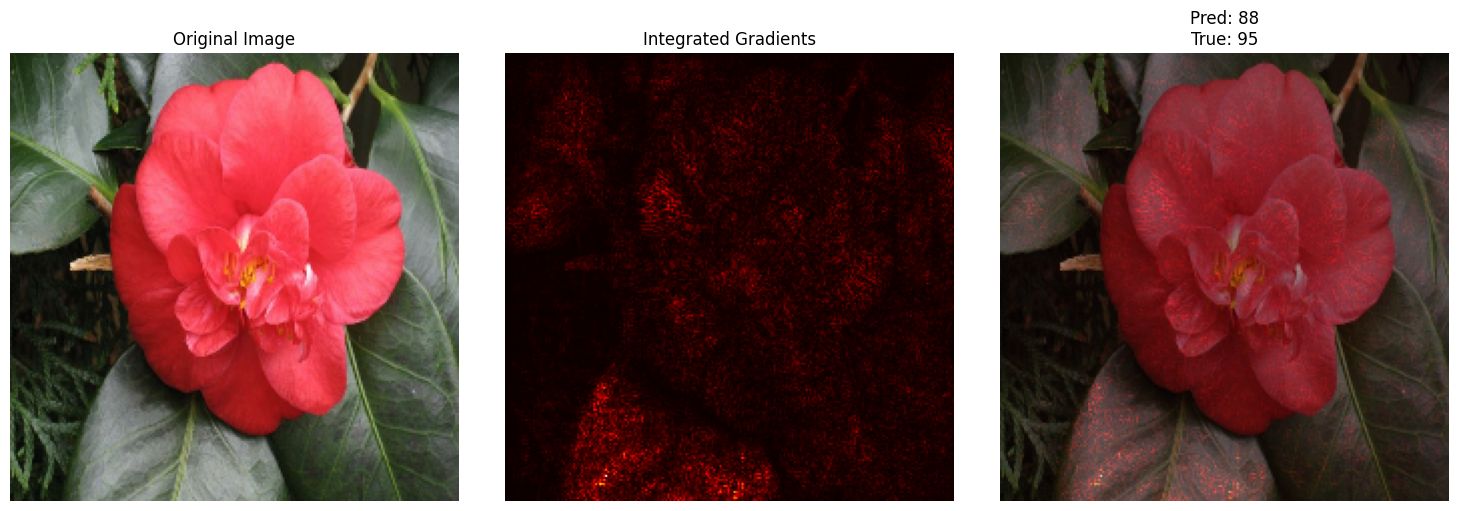

In [11]:
# === IMPLEMENTACIÓN DE INTEGRATED GRADIENTS ===

def apply_integrated_gradients(model, image, class_idx, baseline=None, steps=50):
    """
    Aplica Integrated Gradients para explicar predicción

    Args:
        model: Modelo entrenado
        image: Imagen [1, H, W, 3]
        class_idx: Clase objetivo
        baseline: Imagen baseline (default: imagen negra)
        steps: Número de pasos de integración

    Returns:
        attribution: Mapa de attribution
    """
    # Baseline (imagen negra por defecto)
    if baseline is None:
        baseline = tf.zeros_like(image)

    # Generar alphas para interpolación
    alphas = tf.linspace(0.0, 1.0, steps)

    # Función para calcular gradientes
    @tf.function
    def compute_gradients(images, target_class):
        with tf.GradientTape() as tape:
            tape.watch(images)
            predictions = model(images)
            loss = predictions[:, target_class]

        return tape.gradient(loss, images)

    # Interpolar entre baseline e imagen
    interpolated_images = baseline + alphas[:, tf.newaxis, tf.newaxis, tf.newaxis] * (image - baseline)

    # Calcular gradientes para cada interpolación
    gradients = compute_gradients(interpolated_images, class_idx)

    # Aproximación integral (promedio de gradientes)
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    # Integrated gradients
    integrated_grads = (image - baseline) * avg_gradients

    return integrated_grads[0]

def visualize_integrated_gradients(image, attribution, predicted_class, true_class):
    """
    Visualiza Integrated Gradients attribution
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Desnormalizar (mismo que GradCAM)
    img_display = image[0].numpy().copy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    img_display = np.clip(img_display, 0, 1)

    # Original
    axes[0].imshow(img_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Attribution
    attr_display = np.sum(np.abs(attribution.numpy()), axis=-1)
    attr_display = (attr_display - attr_display.min()) / (attr_display.max() - attr_display.min() + 1e-8)

    axes[1].imshow(attr_display, cmap='hot')
    axes[1].set_title("Integrated Gradients")
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(img_display)
    axes[2].imshow(attr_display, cmap='hot', alpha=0.5)
    axes[2].set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# === APLICAR INTEGRATED GRADIENTS ===

print("🔍 Aplicando Integrated Gradients...")

attribution = apply_integrated_gradients(
    model,
    test_image,
    class_idx=predicted_class,
    baseline=None,
    steps=50
)

visualize_integrated_gradients(test_image, attribution, predicted_class, test_label)